# Exercise 04: Unsupervised ML and Feature Engineering
10/10/2022 (Author: Sophia Kuhn and Diana Steffen)
09/10/2023 (Update: Vera Balmer)

Course: Scientific Machine and Deep Learning for Design and Construction in Civil Engineering by M. A. Kraus, D. Griego and R. Rust

For Questions on this Exercise: vera.balmer@ai.ethz.ch

## Notebook Content
- [1. Clustering](#Clustering)
    - 1.1 Data set
    - 1.2 Clustering Algorithms
        - 1.2.1 Kmeans
        - 1.2.2 DBSCAN
- [2. Feature Engineering](#FE)
    - 2.1 Continuous Data
    - 2.2 Image Data

### Package Installation
The following packages are needed and should be installed.

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.cluster import DBSCAN
import os
import glob
from time import time
from IPython.display import Image
import gower

In [3]:
### installation commands
# conda install pandas
# conda install -c anaconda seaborn
# conda install -c anaconda scikit-learn
# pip install gower

## <a name="Clustering"></a>1. Clustering

A common approach at unsupervised learning is cluster analysis. The goal is to group the data items such that items belonging to the same group show comparable properties. There are various algorithms for performing cluster analysis, which can differ in their understanding of clusters or similarity measures.

### 1.1 Data Set

In this tutorial, we will use the concrete data set for the clustering task. 

Explanation of features in the data set [1]:

$$
\begin{array}{ll}
\text { Variable } & \text { Description } \\
\hline \text { Cement } & \mathrm{kg} \text { in a } m^{3} \text { of mixture } \\
\hline \begin{array}{l}
\text { Blast Furnace } \\
\text { Slag }
\end{array} & \mathrm{kg} \text { in a } m^{3} \text { of mixture } \\
\hline \text { Fly Ash } & \mathrm{kg} \text { in a } m^{3} \text { of mixture } \\
\hline \text { Water } & \mathrm{kg} \text { in a } m^{3} \text { of mixture } \\
\hline \text { Superplasticizer } & \mathrm{kg} \text { in a } m^{3} \text { of mixture } \\
\hline \text { Coarse Aggregate } & \mathrm{kg} \text { in a } m^{3} \text { of mixture } \\
\hline \text { Fine Aggregate } & \mathrm{kg} \text { in a } m^{3} \text { of mixture } \\
\hline \text { Age } & \text { Age (in days) of concrete mix } \\
\hline \text { Concrete } & \text { measure in megapascals (MPa) } \\
\text { Compressive } & \\
\text { Strength } & \\
\hline
\end{array}
$$

In [4]:
concrete_full = pd.read_csv('concrete_full.csv') 
# we need to ignore the first column, since it only contains an additional index to the data
concrete_full.head()

Cement  Blast_Furnace_Slag  Fly_Ash  Water  Superplasticizer  \
0   251.4                 0.0    118.3  188.5               6.4   
1   339.0                 0.0      0.0  197.0               0.0   
2   250.0                 0.0     95.7  187.4               5.5   
3   233.8                 0.0     94.6  197.9               4.6   
4   350.0                 0.0      0.0  186.0               0.0   

   Coarse_Aggregate  Fine_Aggregate  Age  Strength  
0            1028.4           757.7   56     36.64  
1             968.0           781.0    7     20.97  
2             956.9           861.2   56     38.33  
3             947.0           852.2  100     34.56  
4            1050.0           770.0   28     34.29

In [5]:
concrete_full.describe()

Cement  Blast_Furnace_Slag      Fly_Ash        Water  \
count  1030.000000         1030.000000  1030.000000  1030.000000   
mean    281.167864           73.895825    54.188350   181.567282   
std     104.506364           86.279342    63.997004    21.354219   
min     102.000000            0.000000     0.000000   121.800000   
25%     192.375000            0.000000     0.000000   164.900000   
50%     272.900000           22.000000     0.000000   185.000000   
75%     350.000000          142.950000   118.300000   192.000000   
max     540.000000          359.400000   200.100000   247.000000   

       Superplasticizer  Coarse_Aggregate  Fine_Aggregate          Age  \
count       1030.000000       1030.000000     1030.000000  1030.000000   
mean           6.204660        972.918932      773.580485    45.662136   
std            5.973841         77.753954       80.175980    63.169912   
min            0.000000        801.000000      594.000000     1.000000   
25%            0.000000        932.000000      730.950000     7.000000   
50%            6.400000        968.000000      779.500000    28.000000   
75%           10.200000       1029.400000      824.000000    56.000000   
max           32.200000       1145.000000      992.600000   365.000000   

          Strength  
count  1030.000000  
mean     35.817961  
std      16.705742  
min       2.330000  
25%      23.710000  
50%      34.445000  
75%      46.135000  
max      82.600000

<AxesSubplot: >

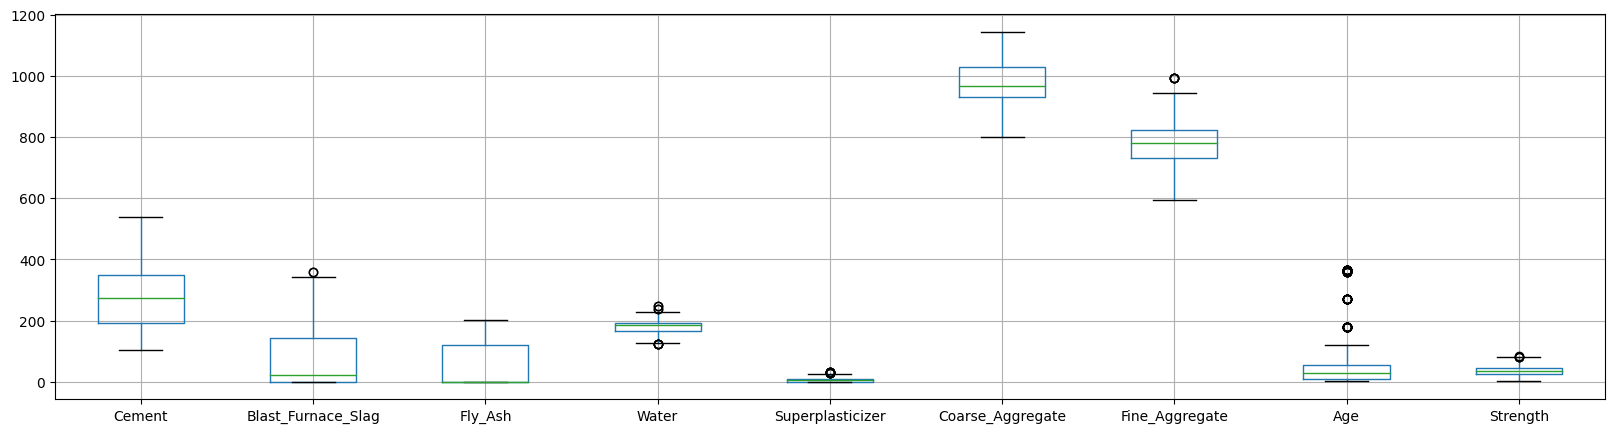

In [12]:
concrete_full.boxplot(figsize=(20,5))

As usual, we scale the data to unit variance and remove the mean.

### 1.2 Clustering Algorithms

Many algorithms for clustering data exist. Depending on the use case and properties of the data, one or the other might be better suited. Here, we are going to see two example algorithms: [KMeans](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html) and [DBSCAN](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.DBSCAN.html#sklearn.cluster.DBSCAN).

The sklearn python library provides many more models you can use. An overview on those with a graphical representation of their behaviour for different data sets can be found [here](https://scikit-learn.org/stable/modules/clustering.html#overview-of-clustering-methods).

#### 1.2.1 KMeans
The Kmeans algorithm tries to find clusters which minimize inertia. This means that within a cluster, the sum-of-squares is minimized:

Cost-Function:

$$C=\sum_{i=1}^{k} \sum_{j=1}^{n} d\left(x_{j}, \mu_{i}\right)=\sum_{i=1}^{k} \sum_{j=1}^{n}\left\|x_{j}-\mu_{i}\right\|^{2}$$


$$\begin{array}{ll}d\left(x_{j}, \mu_{i}\right) & \text { Distance Measure: Euclidian } \\ n & \text { Number of elements (in a cluster) } \\ \boldsymbol{k} & \text { Number of clusters }\end{array}$$

You must provide the number of clusters **k**. To choose a reasonable k-value for the data set at hand, methods such as the **Elbow-Method** and the **Silhouette analysis** are often used. See Appendix B for the implementation of these methods.

The algorithm consists of three steps:

*initialisation*

- Choose *k* cluster centers (centroids), e.g. by selecting k random items from the data set.

*optimisation loop*

- assign each sample to its nearest centroid
- for each centroid, compute the mean value of all assigned samples, and use these as new centroids

The optimisation steps are repeated until the change of centroids between steps falls below a certain threshold. 

The algorithm is sensitive to its initial choice in the initialization step. It may converge to different local minima, depending on its initialization. Therefore, it is important to run the algorithm several times with different initializations and then choose the minimum of all results (global minimum). \
Resource: [1]



In [13]:
# choose numner of clusters (see Appendix B)
k=3

In [14]:
kmeans = KMeans(n_clusters=k, random_state=6).fit(concrete_full)
predicted = kmeans.predict(concrete_full)
predicted

array([1, 0, 1, ..., 1, 2, 2])

In [15]:
centroids = kmeans.cluster_centers_
columns_names=concrete_full.columns
centroids_df=pd.DataFrame(centroids, columns=[columns_names])
centroids_df.head(6)

Cement Blast_Furnace_Slag     Fly_Ash       Water Superplasticizer  \
0  399.374328          30.935224   26.037612  182.677313         6.257313   
1  224.798841          11.423188  101.924928  173.622319         7.020000   
2  223.591143         176.595429   34.078000  188.336286         5.350571   

  Coarse_Aggregate Fine_Aggregate        Age   Strength  
0       959.016716     757.996119  58.704478  42.523582  
1      1016.412754     814.601739  39.063768  29.572609  
2       943.352857     748.061714  39.682857  35.555857

To understand and evaluate the result of the clustering, we are plotting the identified clusters in 2D scatter plots. It is important to understand, that these are 2D projections of the multi-dimensional clusters.

(In Appendix A you can see an example of how PCA can be used to reduce the feature space to 2-dimensions in order to visualize the full multi-dimensional clusters in 2D.)



In [17]:
#defining markers/colors to identify categories
markers=['*', 's', '<', 'o', 'X', 'H', 'p', 'h', '8', 'D', 'd', 'P']
colorName = ['black','red','green','purple','blue', 'orange']


#creating plotting function
def plot_cluster_2D(figNo, n_clusters, clusterPred, clusterCenter, Data, xAxis, yAxis, withOutliers=False):
    #Inputs:
    # figNO: Nr. of Figure
    # n_clusters: nr. of clutsers 
    # clusterPred: predicted clusters
    # clusterC: cluster centers
    # Data: DataFrame
    #xAxis: name of column in the Data that should be plotted on the x axis
    #yAxis: name of column in the Data that should be plotted on the y axis
    # withOutliers: False/ True

    fig = plt.figure(figNo)
    ax = fig.add_subplot(1,1,1)
    
    for j in range(n_clusters):
        #fliter dataset  for current category cluster j
        index = np.flatnonzero(clusterPred == j) # returns all indexes (rows) of the dataframe that belong to the cluster j
        singClusterData= Data.iloc[index,:]
        # extract x and y series
        x=singClusterData[xAxis]
        y=singClusterData[yAxis]
        #create individual scatter plot with color/marker coding of cluster j
        ax.scatter(x ,y,c=colorName[j],s=60,alpha=0.2,marker=markers[j],label="Cluster {}".format(j))
        # plot cluster center of cluster j
        if clusterCenter is not None:
            ax.scatter(clusterCenter[xAxis].loc[j]  ,clusterCenter[yAxis].loc[j],c=colorName[j],s=100,marker='P')#,label="Mean of {}".format(j))

    #end:for j in range noC
    
    #plot Outliers
    if withOutliers==True:
        index = np.flatnonzero(clusterPred == -1)
        for a,i in enumerate(index): # go individually through outlier
            x=Data[xAxis].iloc[i]
            y=Data[yAxis].iloc[i]
            if a==0:
                ax.scatter(x ,y,c='darkviolet',s=60,alpha=1.0,marker="${}$".format(a), label="Outliers")
            else:
                ax.scatter(x ,y,c='darkviolet',s=60,alpha=1.0,marker="${}$".format(a))
    
    
    ax.set_xlabel(xAxis)
    ax.set_ylabel(yAxis)
    ax.grid(True,linestyle='-',color='0.75')
    plt.legend()
    plt.show()
    
#end: def cat_plot_2D()

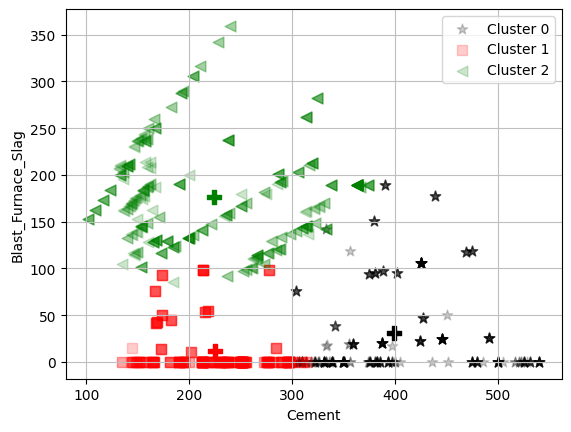

In [18]:
plot_cluster_2D(1, n_clusters=k, clusterPred=predicted, clusterCenter=centroids_df, 
                Data=concrete_full,xAxis="Cement", yAxis='Blast_Furnace_Slag')

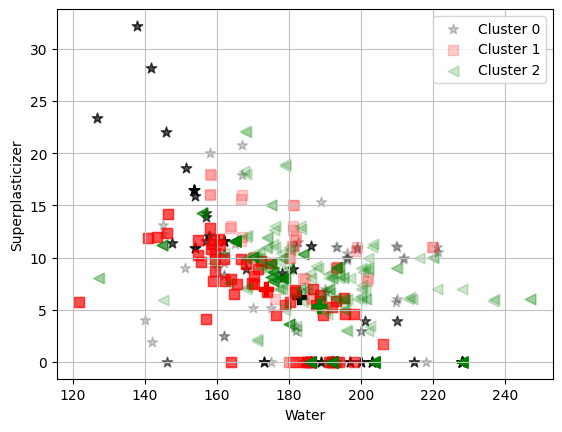

In [19]:
plot_cluster_2D(1, n_clusters=k, clusterPred=predicted, clusterCenter=centroids_df, 
                Data=concrete_full,xAxis="Water", yAxis='Superplasticizer')


Visible is that if no data transformation is applied to the features, the K-means algorithm finds clusters that are well separated in the property such `Cement` and `Blast_Fumace_Slag`, but are not well separated for other properties such as `Water` .

This shows while all properties are considered in the clustering process the properties with the largest value ranges dominate the clustering results. This can be explained by looking at the cost function that the k-means algorithm minimizes. 


$$C=\sum_{i=1}^{k} \sum_{j=1}^{n} d\left(x_{j}, \mu_{i}\right)=\sum_{i=1}^{k} \sum_{j=1}^{n}\left\|x_{j}-\mu_{i}\right\|^{2}$$


$$\begin{array}{ll}d\left(x_{j}, \mu_{i}\right) & \text { Distance Measure: Euclidian } \\ n & \text { Number of elements (in a cluster) } \\ \boldsymbol{k} & \text { Number of clusters }\end{array}$$

The larger absolute distances in the `Cement` feature increases the cost significantly more than the comparably small absolute distances between many other present features (see boxplots below).



--> We will first standardize the data. We scale the data to unit variance and remove the mean.

<AxesSubplot: >

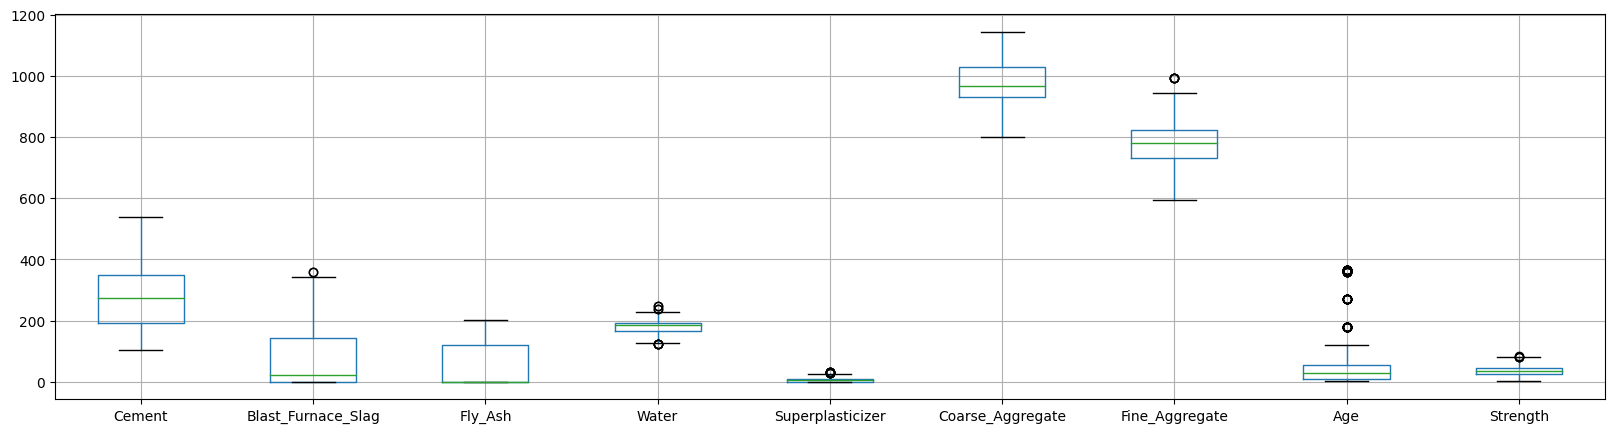

In [20]:
concrete_full.boxplot(figsize=(20,5))

In [21]:
#standardize the data
scaler = StandardScaler()
sc_concrete_full = scaler.fit_transform(concrete_full)

In [22]:
kmeans = KMeans(n_clusters=k, random_state=6).fit(sc_concrete_full)
predicted = kmeans.predict(sc_concrete_full)
predicted

array([0, 2, 0, ..., 0, 0, 2])

<AxesSubplot: >

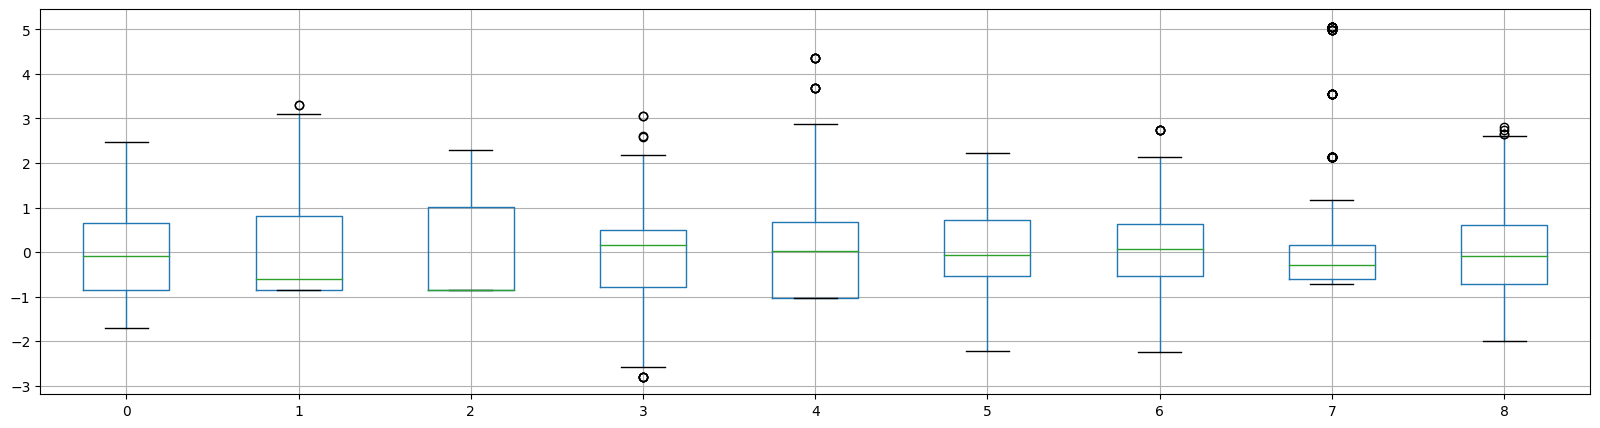

In [32]:
pd.DataFrame(sc_concrete_full).boxplot(figsize=(20,5))

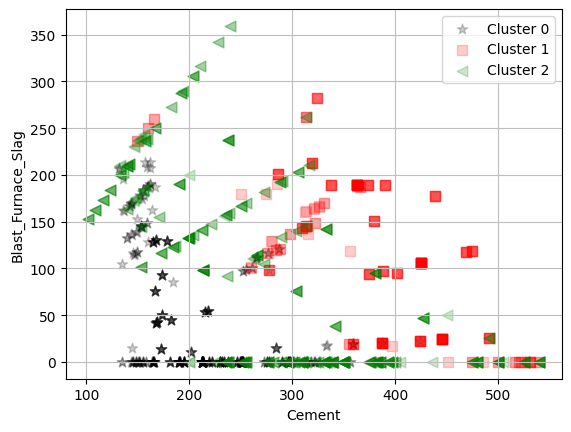

In [31]:
plot_cluster_2D(1, n_clusters=k, clusterPred=predicted, clusterCenter=None, 
                Data=concrete_full,xAxis="Cement", yAxis='Blast_Furnace_Slag')

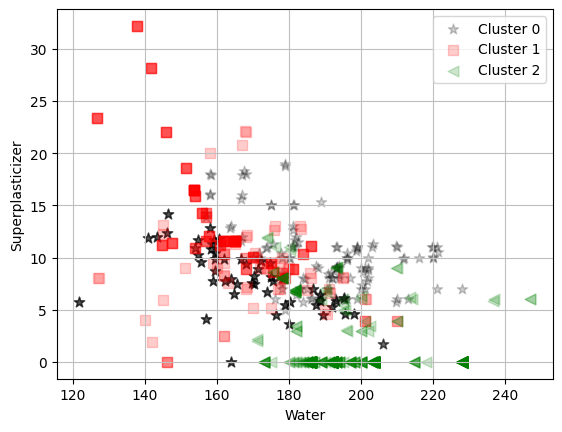

In [24]:
plot_cluster_2D(1, n_clusters=k, clusterPred=predicted, clusterCenter=None, 
                Data=concrete_full,xAxis="Water", yAxis='Superplasticizer')

Now the clusters are well separated in all dimensions.
By standardizing the data before clustering we equalize the contribution of the dimensions in the clustering process. The clustering process is not dominated by the dimensions with large value ranges anymore, rather each dimension is equally considered in the clustering process.


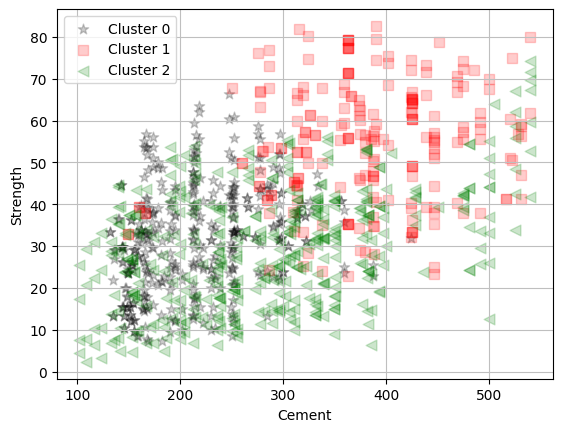

In [25]:
plot_cluster_2D(1, n_clusters=k, clusterPred=predicted, clusterCenter=None, 
                Data=concrete_full,xAxis="Cement", yAxis='Strength')

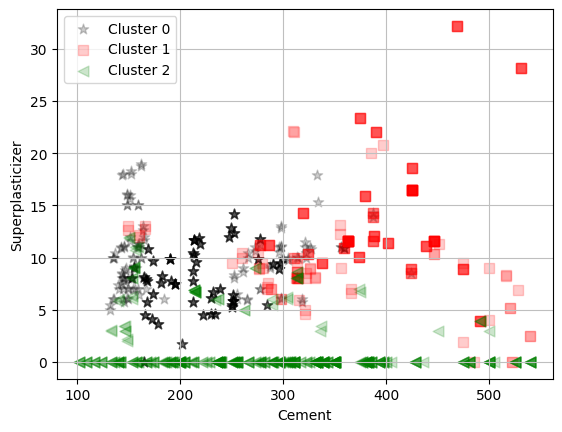

In [26]:
plot_cluster_2D(1, n_clusters=k, clusterPred=predicted, clusterCenter=None, 
                Data=concrete_full,xAxis="Cement", yAxis='Superplasticizer')

#### 1.2.2 DBSCAN

DBSCAN = Density-Based Spatial Clustering of Applications with Noise

DBSCAN is another algorithm provided by scikit-learn for performing cluster analysis. 


The idea of the DBSCAN algorithm is to separate areas of high density from areas of low density. 

The algorithm needs two parameters:
- ```min_samples``` (default = 5): The number of points needed in the neighbourhood of a point for it to be considered a core point.
- ```eps``` (default = 0.5): The maximum distance between two points s.t. they are considered to be in the neighbourhood of each other.

These two parameters define what we mean by *density*; higher ```min_samples``` and lower ```eps``` indicate higher density necessary to form a cluster.

Resource: [4]


In [27]:
Image("DBSCAN_.png")
# source [5]

###### Comparison KMeans and DBSCAN

While k-means is centroid-based, DBSCAN is a density-based clustering algorithm.

- For the DBSCAN the number of clusters does not need to be defined beforehand. The algorithm can automatically detect the number of clusters present in the data set. 
- DBSCAN clusters do not have to be convex but can have any shape. The KMeans algorithm can only find spherical-convex clusters which tend to have equal sizes.
- While the K-Means algorithm assigns all data points to a cluster the DBSCAN distinguished between clustered points and outliers. 




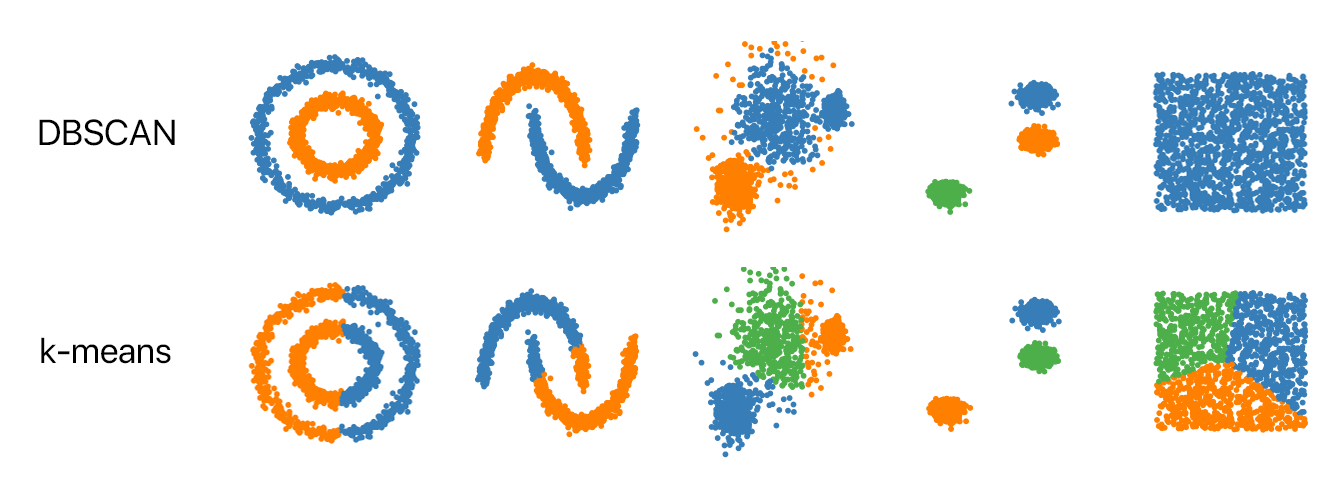

In [28]:
Image("KMeans_vs_DBSCAN.png")
# source [6]

In [29]:
# apply DBSCAN algorithm to our standardized data
db = DBSCAN(eps=0.5, min_samples=8).fit(sc_concrete_full)
labels = db.labels_
print(labels[1:100])

[-1 -1 -1  1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1  0 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  3 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1]


In [33]:
# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print("Estimated number of clusters: %d" % n_clusters_)
print("Estimated number of noise points: %d" % n_noise_)

Estimated number of clusters: 4
Estimated number of noise points: 974


In [34]:
plot_cluster_2D(1, n_clusters=n_clusters_, clusterPred=labels, clusterCenter=None, 
                Data=concrete_full,xAxis="Cement", yAxis='Strength')

Now we increase Epsilon and see what happens:

In [35]:
# apply DBSCAN algorithm to our data 
db = DBSCAN(eps=1.0, min_samples=15).fit(sc_concrete_full)
labels = db.labels_
print(labels[1:100])

[ 1  3  3  1 -1 -1  0 -1  3 -1 -1  0  0 -1 -1  4 -1 -1 -1 -1 -1  5 -1 -1
 -1 -1  4  1 -1 -1 -1  0 -1 -1 -1  1 -1 -1  1  2 -1 -1 -1 -1 -1 -1  1 -1
 -1  1 -1 -1  1 -1  0 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  2 -1  1  1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  0  0 -1 -1 -1 -1 -1 -1 -1  4 -1 -1 -1
 -1 -1 -1]


In [36]:
# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print("Estimated number of clusters: %d" % n_clusters_)
print("Estimated number of noise points: %d" % n_noise_)

Estimated number of clusters: 6
Estimated number of noise points: 721


In [37]:
plot_cluster_2D(1, n_clusters=6, clusterPred=labels, clusterCenter=None, 
                Data=concrete_full,xAxis="Cement", yAxis='Strength')

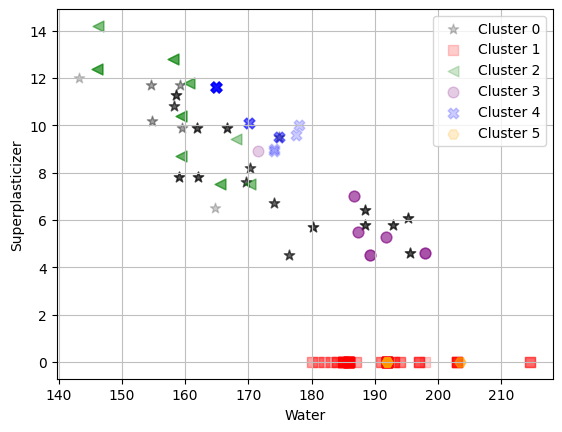

In [38]:
plot_cluster_2D(1, n_clusters=6, clusterPred=labels, clusterCenter=None, 
                Data=concrete_full,xAxis="Water", yAxis='Superplasticizer')

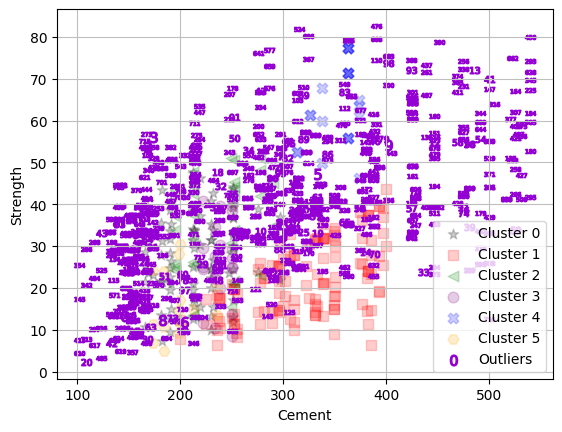

In [39]:
plot_cluster_2D(1, n_clusters=n_clusters_, clusterPred=labels, clusterCenter=None, 
                Data=concrete_full,xAxis="Cement", yAxis='Strength', withOutliers=True)

In [40]:
plot_cluster_2D(1, n_clusters=6, clusterPred=labels, clusterCenter=None, 
                Data=concrete_full,xAxis="Fine_Aggregate", yAxis='Superplasticizer', withOutliers=True)

## <a name="FE"></a>2. Feature Engineering

Sometimes, our data is very high dimensional which makes training machine learning models very expensive and time-consuming. Depending on the machine learning task, not all features might be similarly important. Some other times, data might be too coarse and we need more data points or more data about individual data features. 

**Feature Engineering** is the task of reducing or augmenting the feature space so that it better fits the intended machine learning task. 

### 2.1 Continuous and Catergorical Data

Throughout the tutorials, we have already seen many applications of feature engineering. Examples are data standardization, data scaling, encoding categorical features, handling missing values, remove collinearity or drop insignificant features.

We will not go further into this topic and instead skip to another use case, feature engineering with image data.


### 2.2 Image Data

Images are very high dimensional data items, as they can be represented by a list of pixel values of the dimension (width * height) and if the image is coloured, an additional three dimensions for Red, Green, and Blue (RGB) channels. For images, dimensionality reduction might therefore be interesting to reduce the complexity of data items.

Let us load a sample data set which we will also use in the CNN exercise.
It contains images of walls with and without cracks. It can be downloaded from [Kaggle](https://www.kaggle.com/datasets/arunrk7/surface-crack-detection) or [Mendeley Data](https://data.mendeley.com/datasets/5y9wdsg2zt/2).

In [41]:
from PIL import Image, ImageOps

def import_images_from_folder(folder, limit=None):
    images = []
    for filename in glob.iglob(folder + '/*.jpg'):
        img = Image.open(filename)
        images.append(img)
        if limit:
            if len(images)>limit:
                break
    return images

In [42]:
# Import images
cracks_pos = import_images_from_folder('archive_small/Positive', 100)
cracks_neg = import_images_from_folder('archive_small/Negative', 100)

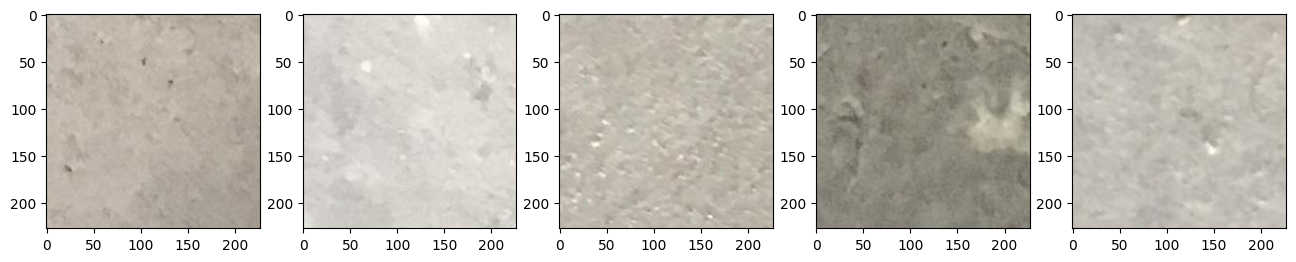

In [43]:
fig, axs = plt.subplots(1,5, figsize=(16,8))
for i in range(5):
    axs[i].imshow(cracks_neg[i]) 

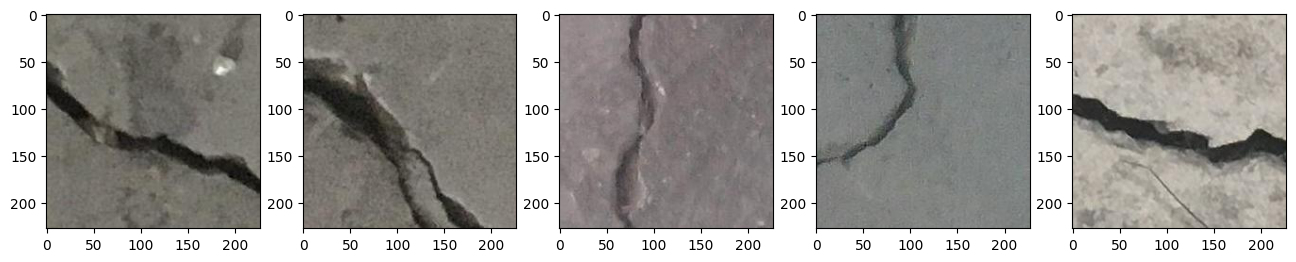

In [44]:
fig, axs = plt.subplots(1,5, figsize=(16,8))
for i in range(5):
    axs[i].imshow(cracks_pos[i]) 

If we look at the image shape, we can see that the images are stored in RGB format and have a size of (227,227,3). A first step would be to get rid of the colour dimension and convert the image to greyscale. We can use the ```ImageOps``` functionality of PIL for this task.

In [45]:
image_shape = np.array(cracks_neg[0]).shape
print(image_shape)

(227, 227, 3)


In [46]:
grey_neg = []
grey_pos = []
for image in cracks_neg:
    grey_image = ImageOps.grayscale(image)
    grey_neg.append(grey_image)
    
for image in cracks_pos:
    grey_image = ImageOps.grayscale(image)
    grey_pos.append(grey_image)

In [47]:
image_shape = np.array(grey_neg[0]).shape
print(image_shape)

(227, 227)


In [48]:
fig, axs = plt.subplots(1,5, figsize=(16,8))
for i in range(5):
    axs[i].imshow(grey_pos[i], cmap='gray') 

In [49]:
print('values example first image:')
print('smallest pixel value:', np.min(grey_pos[0]), 'highest pixel value:', np.max(grey_pos[0]))

values example first image:
smallest pixel value: 0 highest pixel value: 251


Since our original images where coloured, our pixel values lie in [0, 255]. Ideally, data used for machine learning lies in [0,1]. We therefore apply **scaling** to further engineer our features:

In [50]:
def normalize(arr):
    return np.array(list(map(lambda x: x/255, arr)))

In [51]:
s_pos = []
s_neg = []
for image in grey_pos:
    scaled = normalize(np.array(image))
    s_pos.append(scaled)
for image in grey_neg:
    scaled = normalize(np.array(image))
    s_neg.append(scaled)

In [52]:
image_shape = np.array(s_neg[0]).shape
print(image_shape)

(227, 227)


In [53]:
print('smallest pixel value:', np.min(s_pos[0]), 'highest pixel value:', np.max(s_pos[0]))

smallest pixel value: 0.0 highest pixel value: 0.984313725490196


### PCA
Another strategy to reduce the dimensionality is the [Principal Component Analysis](https://scikit-learn.org/stable/modules/decomposition.html#pca).

(Other dimensionality reduction algorithms: UMAP,  t-SNE)

The idea behind PCA is to project high dimensional data to a lower dimension by finding principal components which capture the directions with the highest variance while minimizing the reconstruction error.

For image data feature engineering, we can use PCA to reduce the information contained in one image to the principal features, and by doing so compressing the image. Ideally, the principal components will contain all the necessary characteristics about the represented image.

In [54]:
def compute_decomposition(n_components, data, image_size):
    min_components = min(len(data), len(data[0]))
    n_components = min(n_components, min_components)
    print(
        "Extracting the top %d features from %d images" % (n_components, len(data))
    )
    t0 = time()
    model = PCA(n_components=n_components, random_state=21).fit(data)
          
    print("done in %0.3fs" % (time() - t0))

    eigenfaces = model.components_.reshape((n_components, image_size[0], image_size[1]))

    print("Projecting the input data on the eigenfaces orthonormal basis")
    t0 = time()
    data_dec = model.transform(data)
    print("done in %0.3fs" % (time() - t0))
    return model, data_dec, eigenfaces

In [55]:
all_images = s_pos + s_neg

In [56]:
print(len(s_pos), len(s_neg), len(all_images))

101 101 202


In [57]:
all_flat = []
for image in all_images:
    flat_img = image.flatten()
    all_flat.append(flat_img)

In [58]:
all_flat[0].shape

(51529,)

In [59]:
pca, data_pca, eigenfaces_pca = compute_decomposition(20, all_flat, image_shape)

Extracting the top 20 features from 202 images
done in 0.535s
Projecting the input data on the eigenfaces orthonormal basis
done in 0.091s


In [60]:
def show_images(eigenfaces):
    fig = plt.figure(figsize=(16, 10))
    n = len(eigenfaces)
    
    for i in range(n):
        ax = fig.add_subplot(int(np.floor(n/5)), 5, i + 1, xticks=[], yticks=[])
        ax.imshow(eigenfaces[i],
                  cmap=plt.cm.bone)

We have now reduced our images from (51529,) to a dimension of (20,). 

We can plot the 'eigenfaces', the principal componets of our data set, to learn how the most important features of our images look like.

In [61]:
show_images(eigenfaces_pca)

We can also reconstruct the initial images from the principal components. This is why we can also think of PCA as a compression algorithm.

In [62]:
images_recons_pca = pca.inverse_transform(data_pca)

In [63]:
images_recons_pca.shape

(202, 51529)

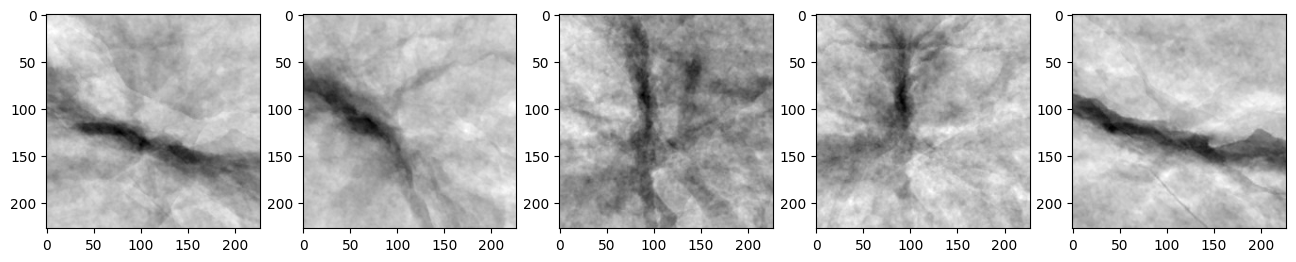

In [64]:
fig, axs = plt.subplots(1,5, figsize=(16,8))
for i in range(5):
    axs[i].imshow(np.reshape(images_recons_pca[i], image_shape), cmap='gray') 

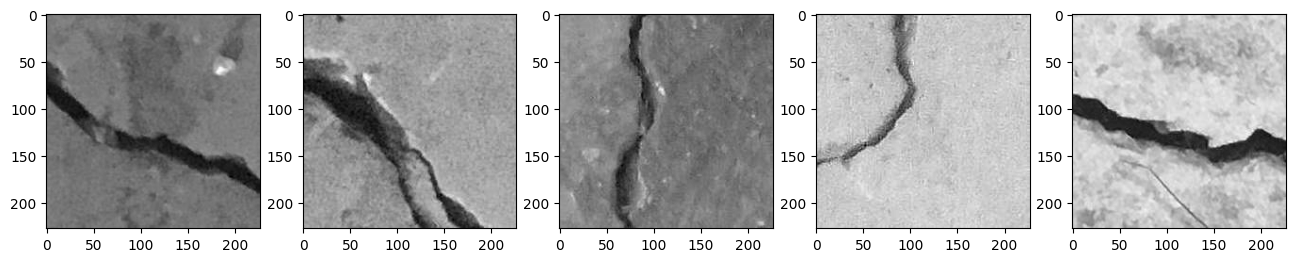

In [65]:
# as a comparison, the uncompressed images
fig, axs = plt.subplots(1,5, figsize=(16,8))
for i in range(5):
    axs[i].imshow(grey_pos[i], cmap='gray') 

PCA is not the only compression or feature reduction technique. Various other approaches can also be used for the same task, depending on the data you are using and the task you want to solve. Some examples are [Non-negative matrix factorization (NMF)](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.NMF.html#sklearn.decomposition.NMF), [Dictionary Learning](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.DictionaryLearning.html#sklearn.decomposition.DictionaryLearning), or [Factor Analysis](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.FactorAnalysis.html#sklearn.decomposition.FactorAnalysis).

### References
[1] https://scikit-learn.org/stable/modules/clustering.html#k-means

[2] https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_digits.html#visualize-the-results-on-pca-reduced-data

[3] https://towardsdatascience.com/k-means-clustering-algorithm-applications-evaluation-methods-and-drawbacks-aa03e644b48a

[4] https://scikit-learn.org/stable/modules/clustering.html#dbscan

[5] https://mineracaodedados.wordpress.com/2018/02/09/a-gentle-introduction-to-dbscan/

[6] https://www.kdnuggets.com/2020/04/dbscan-clustering-algorithm-machine-learning.html

# Appendix

### Appendix A: Using PCA to visualize high-dimensional clustering example in 2D


Since our data is high dimensional, we need to reduce the feature space to visualise our results. We can use PCA to achieve this. The following function reduces the feature space to two dimensions and plots which regions of the feature space get assigned to which cluster [2].


In [55]:
def plot_pca(data, model):
    reduced_data = PCA(n_components=2).fit_transform(data)
    model.fit(reduced_data)

    # Step size of the mesh. Decrease to increase the quality of the VQ.
    h = 0.02  # point in the mesh [x_min, x_max]x[y_min, y_max].

    # Plot the decision boundary. For that, we will assign a color to each
    x_min, x_max = reduced_data[:, 0].min() - 1, reduced_data[:, 0].max() + 1
    y_min, y_max = reduced_data[:, 1].min() - 1, reduced_data[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

    # Obtain labels for each point in mesh. Use last trained model.
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])


    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    plt.figure(1)
    plt.clf()
    plt.imshow(
        Z,
        interpolation="nearest",
        extent=(xx.min(), xx.max(), yy.min(), yy.max()),
        cmap=plt.cm.Paired,
        aspect="auto",
        origin="lower",
    )

    plt.plot(reduced_data[:, 0], reduced_data[:, 1], "k.", markersize=2)
    # Plot the centroids as a white X
    centroids = model.cluster_centers_
    plt.scatter(
        centroids[:, 0],
        centroids[:, 1],
        marker="x",
        s=169,
        linewidths=3,
        color="w",
        zorder=10,
    )
    plt.title(
        "K-means clustering on the concrete dataset (PCA-reduced data)\n"
        "Centroids are marked with white cross"
    )
    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)
    plt.xticks(())
    plt.yticks(())
    plt.show()

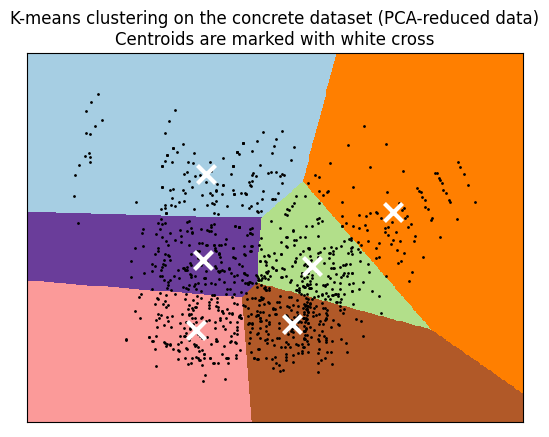

In [58]:
plot_pca(sc_concrete_full, kmeans)

### Appendix B: Choosing k for k-means clustering
#### Elbow Method

A common way of studying which number of clusters would best fit our data is to do an **Elbow-Study**. Basically, we try out some different values for *k* and keep track of the *sum of squared distances*. Each *k* at which this sum begins to flatten (we see an 'elbow' in the plot) represents a good amound of cluster centers. [3]

In [59]:
# Run the Kmeans algorithm and get the index of data points clusters
def elbow_study(data, maxK):
    sse = []
    list_k = list(range(1, maxK))

    for k in list_k:
        km = KMeans(n_clusters=k)
        km.fit(data)
        sse.append(km.inertia_)

    # Plot sse against k
    plt.figure(figsize=(6, 6))
    plt.xticks(list_k)
    plt.plot(list_k, sse, '-o')
    plt.xlabel(r'Number of clusters *k*')
    plt.ylabel('Sum of squared distance');

C:\Users\kuhnso\AppData\Roaming\Python\Python39\site-packages\sklearn\cluster\_kmeans.py:1036: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(


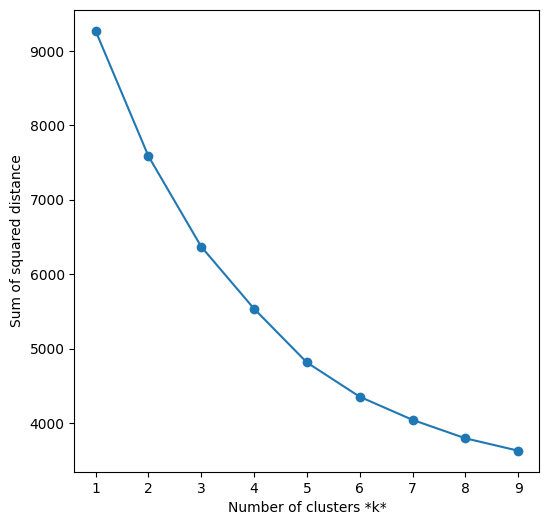

In [61]:
elbow_study(sc_concrete_full, 10)

Unfortunately, we can not really distinguish a clear elbow in this data set. 

#### Silhouette analysis
We can use another approach, silhouette analysis, to get more insights [3]. This approach determines the degree of separation between clusters. For each sample we compute the average distance from all data points in the same cluster (ai) and the average distance from all data points in the closest cluster. From this, we compute the silhouette coefficient: 

$$ \frac{b^{i} - a^{i}}{max(a^i, b^i)} $$

It can take values in the interval [-1,1]. 
- 0 - sample is very close to neighboring clusters
- 1 - sample is far away from neighboring clusters (what we want to achieve)
- -1 - sample is assigned to the wrong cluster

In [62]:
def plot_silhouettes(data, maxK):
    max_avg = 0
    max_k = -1
    for i, k in enumerate(list(range(2, maxK))):
        fig, ax1 = plt.subplots(1, 1)
        fig.set_size_inches(10, 4)

        # Run the Kmeans algorithm
        km = KMeans(n_clusters=k)
        labels = km.fit_predict(data)
        centroids = km.cluster_centers_

        # Get silhouette samples
        silhouette_vals = silhouette_samples(data, labels)

        # Silhouette plot
        y_ticks = []
        y_lower, y_upper = 0, 0
        for i, cluster in enumerate(np.unique(labels)):
            cluster_silhouette_vals = silhouette_vals[labels == cluster]
            cluster_silhouette_vals.sort()
            y_upper += len(cluster_silhouette_vals)
            ax1.barh(range(y_lower, y_upper), cluster_silhouette_vals, edgecolor='none', height=1)
            ax1.text(-0.03, (y_lower + y_upper) / 2, str(i + 1))
            y_lower += len(cluster_silhouette_vals)

        # Get the average silhouette score and plot it
        avg_score = np.mean(silhouette_vals)
        ax1.axvline(avg_score, linestyle='--', linewidth=2, color='green')
        ax1.set_yticks([])
        ax1.set_xlim([-0.1, 1])
        ax1.set_xlabel('Silhouette coefficient values')
        ax1.set_ylabel('Cluster labels')
        ax1.set_title(f'Silhouette plot for k = {k}', y=1.02);
        if avg_score > max_avg:
            max_avg = avg_score
            max_k = k
    print(f'Maximal average silhouette score is {max_avg} at k = {max_k}')

We plot the silhouette coefficient values for all items in the data set for different values for *k*. In the plots, we can see the distribution of silhouette coefficients for all data points. 
We want to choose in a way that minimises negative points (wrong cluster assigned) and has as many items as possible close to 1.

Maximal average silhouette score is 0.2600692884240861 at k = 6


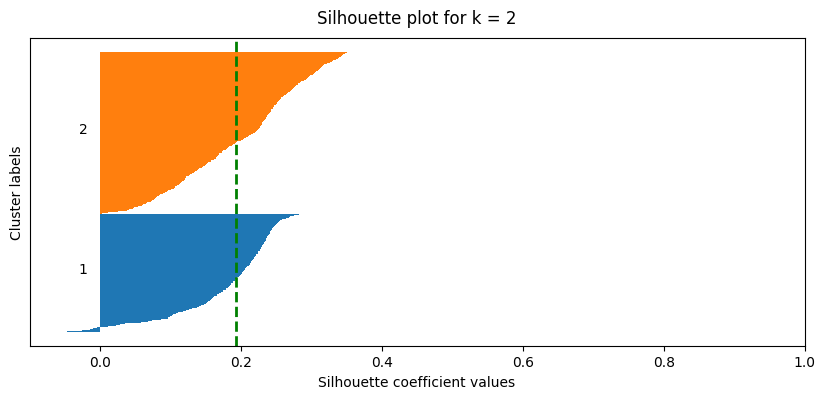

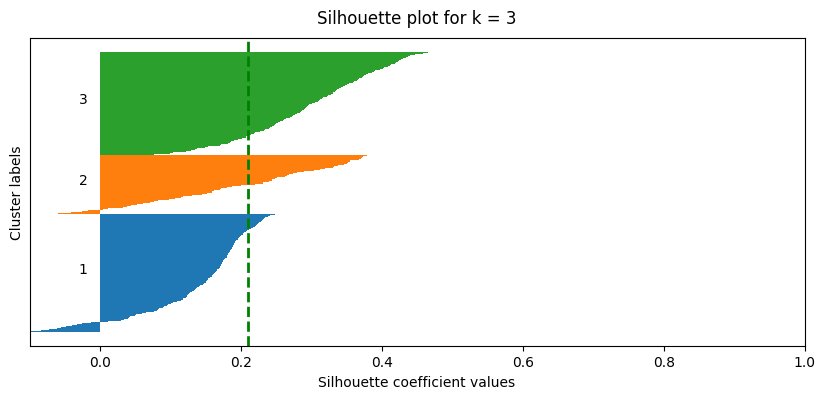

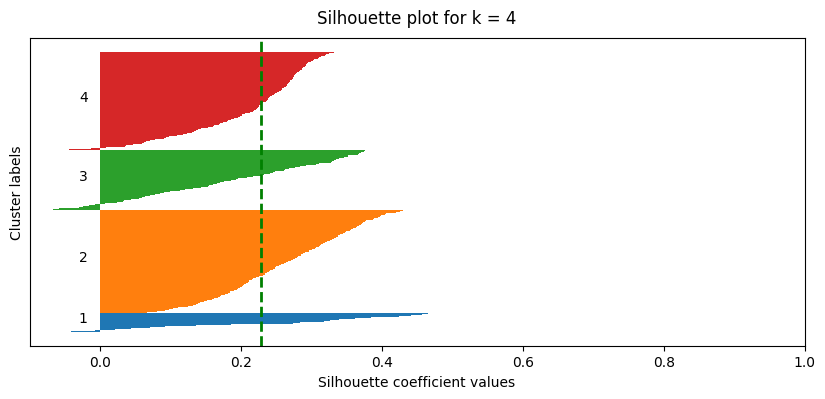

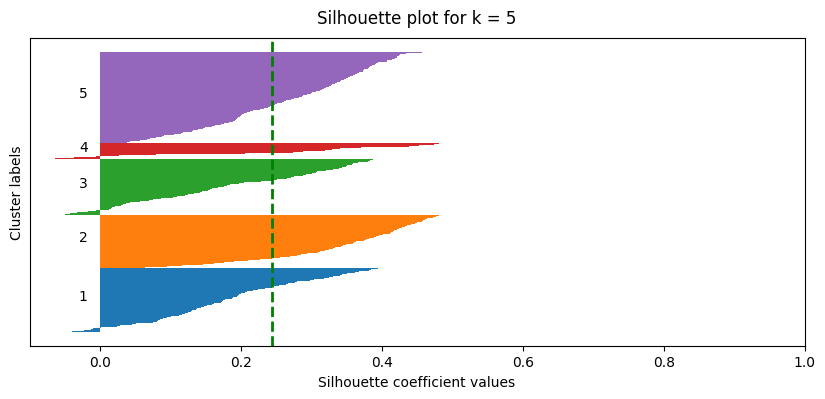

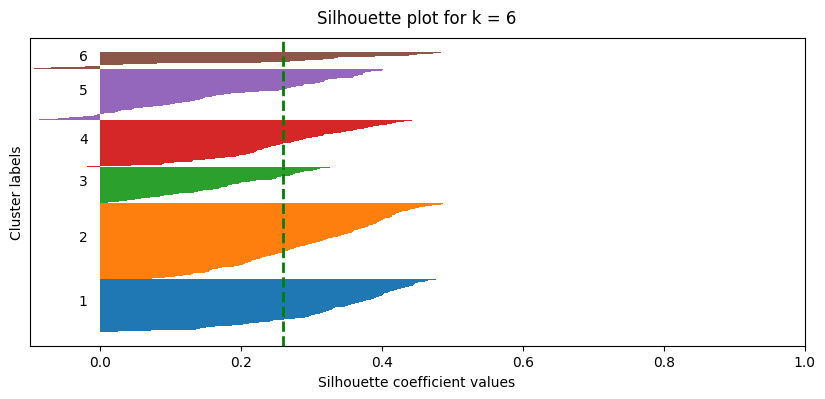

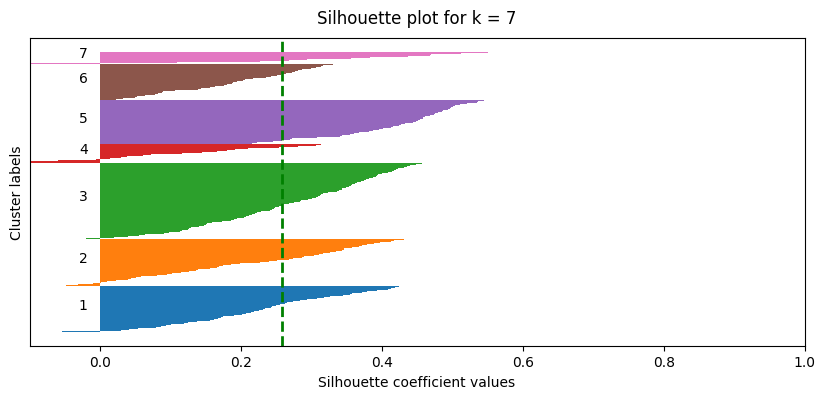

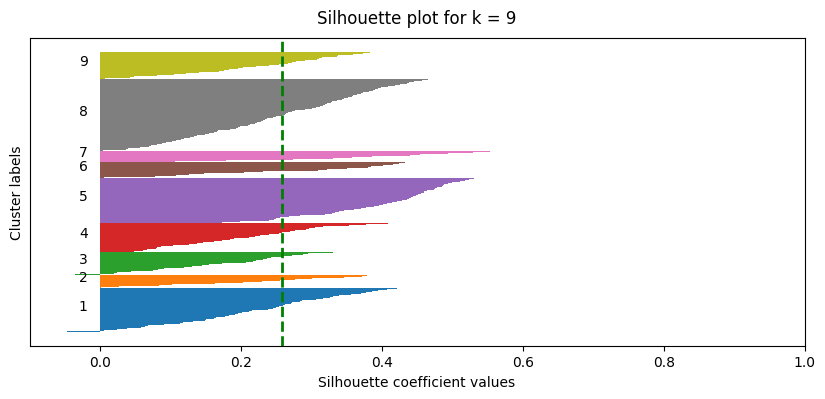

In [63]:
plot_silhouettes(sc_concrete_full, 10)

We decide to use *k = 6* as our number of clusters.